In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
%matplotlib inline
%config Completer.use_jedi = False
np.random.seed(123)

### Define ANN Classifier

In [2]:
class ANN():
    def __init__(self, nodes_in_layer = (2,2,1)):
        # total layers in network
        self.L = len(nodes_in_layer)
        # parameters/theta
        self.theta = []
        for i in range(self.L-1):
            self.theta.append(self.weight_init(nodes_in_layer[i],nodes_in_layer[i+1]))
        # Accumulator of error
        self.delta = [np.zeros(theta_mat.shape) for theta_mat in self.theta]
        # Activations
        self.a = [np.zeros((n_nodes+1,1)) if layer_idx !=self.L-1 \
                  else np.zeros((n_nodes,1)) \
                  for (layer_idx,n_nodes) in list(enumerate(nodes_in_layer))]
        # Local error gradients
        self.d = [np.zeros((n_nodes,1)) for n_nodes in nodes_in_layer]

        
    def weight_init(self, s_j,s_j_plus_1):
        '''Returns a weight matrix having (num of nodes in next layer) rows 
        and (num of nodes in current layer +1) columns
        '''
        return np.random.randn(s_j_plus_1, s_j+1)*np.sqrt(2/s_j) # He initialization
    
    def sigmoid(self,x):
        '''Returns the vector after applying sigmoid activation to its elements'''
        return 1 / (1 + np.exp(-x))
    
    def forward_propagate(self,x):
        '''Forward pass the example x through the network'''
        for l in range(self.L):
            if l == 0: #input layer
                self.a[l] = x
            else:
                # add fixed bias to the previous layer activation
                self.a[l-1] = np.vstack((np.array([+1]),self.a[l-1]))
                # matrix multiply with weight matrix
                # apply sigmoid to obtain current layer activation
                self.a[l] = self.sigmoid(np.matmul(self.theta[l-1], self.a[l-1]))
                
        return self.a[-1] #last layer activation
        
    def back_propagate(self,y):
        # local error gradient at final layer
        self.d[self.L-1] = self.a[-1] -y
        # local error gradient at previous layers upto second layer
        for l in range(self.L-2,0,-1):
            self.d[l] = ( np.matmul(self.theta[l].T,self.d[l+1]) * self.a[l] * (1-self.a[l]) )[1:]
        
        # accumulate error gradient
        for l in range(len(self.delta)):
            self.delta[l] = self.delta[l] + np.matmul(self.d[l+1],self.a[l].T)
        
    def compute_cost(self,X,Y, lamda = 0):
        m = len(X)
        J = 0
        reg_penalty = 0
        for t in range(m):
            x = np.array([X[t]]).T
            y = np.array([Y[t]])
            J += (-1/m) * ( y*np.log(self.forward_propagate(x)) +  (1-y)* np.log(1- self.forward_propagate(x)) )
        for theta_mat in self.theta:
            reg_penalty +=(lamda/(2*m))*np.sum(np.sum(theta_mat**2))
        J += reg_penalty
        return J[0][0]
    
    def compute_gradient(self,X,Y, lamda = 0):
        m = len(X)
        for t in range(m):
            x = np.array([X[t]]).T
            y = np.array([Y[t]])
        
            self.forward_propagate(x)
            self.back_propagate(y)
            
        grad_theta = []
        for l in range(len(self.theta)):
            gradient = (1/m) * (self.delta[l]  + lamda*self.theta[l])
            gradient[0,:] = (1/m)* self.delta[l][0,:]
            grad_theta.append(gradient)
        return grad_theta
    
    def fit(self, X, Y, alpha =0.001, num_iters = 1000, tol = 1e-2, lamda = 0):
        '''Fits the network to given examples (X,Y) using Batch Gradient Descent'''
        J_history = []
        for iteration in range(num_iters):
            J_history.append(self.compute_cost(X,Y, lamda))
            if abs(J_history[-1])<tol:
                break
            grad_theta = self.compute_gradient(X,Y, lamda)
            #self.theta = self.theta - alpha*grad_theta
            self.theta = [thet - alpha*grad_thet for thet, grad_thet in zip(self.theta, grad_theta)]
        return J_history
    
    def predict(self,X_test):
        y_preds = []
        for x in X_test:
            y_preds.append(self.forward_propagate(np.array([x]).T)[0][0])
        return np.array([y_preds]).T
            

### Solve XOR problem

In [3]:
x1 = np.array([0,0])
y1 = 0
x2 = np.array([0,1])
y2 = 1
x3 = np.array([1,0])
y3 = 1
x4 = np.array([1,1])
y4 = 0

X = np.vstack((x1,x2,x3,x4))
Y = np.vstack((y1,y2,y3,y4))

# number of training examples
m = len(X)

In [4]:
X

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [5]:
Y

array([[0],
       [1],
       [1],
       [0]])

In [6]:
m

4

In [19]:
clf = ANN()

<AxesSubplot:>

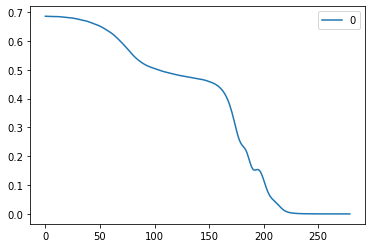

In [20]:
J_history = clf.fit(X,Y, alpha = 0.1, num_iters = 1000, tol = 1e-5, lamda = 0)
pd.DataFrame(J_history).plot()

In [21]:
for t in range(m):
    print('Predicted label of \n{} is \n{}'.format(np.array([X[t]]).T,clf.forward_propagate(np.array([X[t]]).T)) )

Predicted label of 
[[0]
 [0]] is 
[[2.12415223e-06]]
Predicted label of 
[[0]
 [1]] is 
[[0.99999873]]
Predicted label of 
[[1]
 [0]] is 
[[0.99996919]]
Predicted label of 
[[1]
 [1]] is 
[[5.44091602e-06]]


In [25]:
clf.predict(X)>0.5

array([[False],
       [ True],
       [ True],
       [False]])

### Classify Non-linearly separable data using ANN

In [26]:
df = pd.read_csv('data/linearly_inseparable.txt',sep=',', header= None, names= 'x1 x2 y'.split())

In [27]:
df.head()

,x1,x2,y
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      118 non-null    float64
 1   x2      118 non-null    float64
 2   y       118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


In [29]:
df.groupby('y').count()

,x1,x2
y,,
0,60,60
1,58,58


### Visualize the dataset

<AxesSubplot:xlabel='x1', ylabel='x2'>

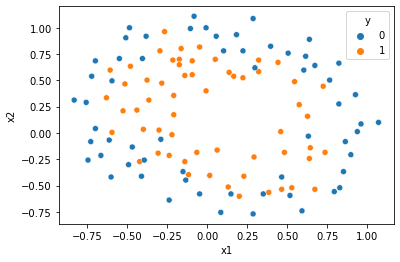

In [30]:
sns.scatterplot(data = df, x = 'x1', y = 'x2', hue = 'y')

In [31]:
X = np.array(df[['x1','x2']])
y = np.array(df[['y']])

### Perform train-test split

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
X_train.shape

(79, 2)

In [34]:
y_test.shape

(39, 1)

### Initialize ANN with 5 layers

In [35]:
clf = ANN(nodes_in_layer=(2,8,5,1)) # 2,8,5,1

### Train the ANN

<AxesSubplot:>

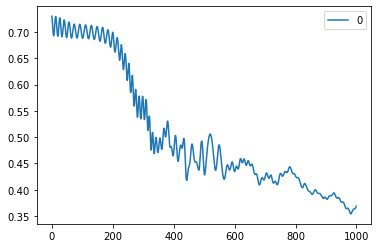

In [36]:
J_history = clf.fit(X_train,y_train, alpha = 0.1, num_iters = 1000, tol = 1e-5, lamda = 0)
pd.DataFrame(J_history).plot()

In [37]:
y_probs = clf.predict(X_test)
y_preds = np.array([1 if prob > 0.5 else 0 for prob in y_probs]).T
print('Accuracy of ANN on test-subset:', 100*np.mean(y_preds==y_test))

Accuracy of ANN on test-subset: 47.928994082840234
